# Experiment 2: Three different depths of models, trained on 5 of the 6 subjects then evaluated on the 6th. Increased number of epochs from experiment 1

*   0 degree aspect angle
*   Models:
    *  2-4
    *  8-16
    *  32-64




## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
# Needed to allow editing using PyCharm
%load_ext autoreload
%autoreload 2

Needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
else:
    BASE_PATH = "C:/Users/macka/Google Drive/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/cifar_initialised/'
MODEL_PATH = BASE_PATH + 'models/original_experiments/experiment_2/'
FIGURE_PATH = BASE_PATH + 'reports/figures/original_experiments/experiment_2/'
REPORT_PATH = BASE_PATH + 'reports/original_experiments/experiment_2/'
    
from src.models.original_models import cnn_various_depths
from src.data import load_data
from src.visualization import multiple_plots

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Found existing installation: src 0.1.0
    Can't uninstall 'src'. No files were found to uninstall.
  Running setup.py develop for src


Using TensorFlow backend.


Import remaining packages

In [0]:
import numpy as np
import sys
from six.moves import cPickle
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model

In [0]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup and Parameter Definition

In [0]:
load_models = False

batch_size = 100
nb_classes = 7
nb_epoch = 500
nb_epoch = 2
nb_train_samples = 35595

# input image dimensions
img_rows, img_cols = 75, 75
# the CIFAR10 images are RGB


# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = load_data.load_data(DATA_PATH, nb_train_samples)

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255 

target_names = ['ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm', 'Clapping', 'PickingUp', 'Sitting', 'Walking']
    
models = {"2-4": {}, "8-16": {}, "32-64": {}}
for name, model in models.items():
    if load_models:
        model["model"] = load_model(MODEL_PATH + name + '.h5')
    else:
        model["model"] = cnn_various_depths.make_model(name, img_rows, img_cols, nb_classes)

## Training and Evaluating Models

In [6]:
for name, model_data in models.items():
    if not load_models:
        # train the model using SGD + momentum.
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model_data["model"].compile(loss='categorical_crossentropy',
                      optimizer=sgd,
                      metrics=['accuracy'])

        history = model_data["model"].fit(
            X_train,
            Y_train,
            batch_size=batch_size,
            epochs=nb_epoch,
            validation_data=(X_test, Y_test),
            shuffle=True, 
            verbose=1)
        model_data["history"] = history

    y_pred = model_data["model"].predict_classes(X_test)
    model_data["classification_report"] = classification_report(np.argmax(Y_test,axis=1), y_pred,target_names=target_names)
    model_data["confusion_matrix"] = confusion_matrix(np.argmax(Y_test,axis=1), y_pred)


Train on 35595 samples, validate on 7119 samples
Epoch 1/2
35595/35595 [==============================] - 10s 272us/step - loss: 1.1131 - acc: 0.5590 - val_loss: 0.1979 - val_acc: 0.9470
Epoch 2/2
35595/35595 [==============================] - 8s 220us/step - loss: 0.2521 - acc: 0.9111 - val_loss: 0.0804 - val_acc: 0.9777
Train on 35595 samples, validate on 7119 samples
Epoch 1/2
35595/35595 [==============================] - 14s 384us/step - loss: 0.5554 - acc: 0.7853 - val_loss: 0.0907 - val_acc: 0.9781
Epoch 2/2
35595/35595 [==============================] - 14s 383us/step - loss: 0.1164 - acc: 0.9611 - val_loss: 0.0835 - val_acc: 0.9813
Train on 35595 samples, validate on 7119 samples
Epoch 1/2
35595/35595 [==============================] - 36s 998us/step - loss: 0.5401 - acc: 0.7898 - val_loss: 0.0554 - val_acc: 0.9865
Epoch 2/2
35595/35595 [==============================] - 34s 948us/step - loss: 0.1046 - acc: 0.9642 - val_loss: 0.0561 - val_acc: 0.9845


## Analysis and Saving of Results

In [0]:
save_graph = True
save_model = True
save_report = True

### Plot and Save graph

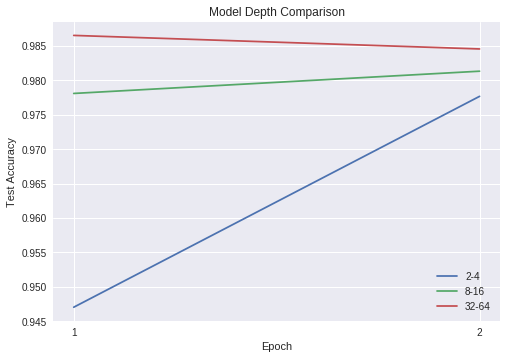

In [8]:
if not load_models:
    multiple_plots.plot_multiple_val_acc(
        models,
        "Model Depth Comparison",
        save=save_graph,
        path=FIGURE_PATH + "different_depths.svg")

### Save Models

In [0]:
if not load_models and save_model:
    for name, model_data in models.items():
        model_data['model'].save(MODEL_PATH + name + '.h5')

### Display and Save Classification Report and Confusion Matricies

In [0]:
if save_report:
    file = open(REPORT_PATH + 'Classification_and_Confusion.txt', 'w') 

    for name, model_data in models.items():
        file.write("--------------------------------------------------\n") 
        file.write("Model Name: " + name + "\n") 
        file.write("Classification Report:\n") 
        file.write(model_data['classification_report'])
        file.write("Confusion Matrix:\n") 
        file.write(np.array2string(model_data['confusion_matrix']) + "\n")

    file.close() 